<a href="https://colab.research.google.com/github/igorgad/covid-ts-it/blob/master/MAE-Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoVID19 Time Series Modeling - MAE Dense

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json
!wget https://covid.saude.gov.br/assets/files/COVID19_20200402.csv

--2020-04-23 14:32:38--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78271 (76K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>]  76.44K  --.-KB/s    in 0.03s   

2020-04-23 14:32:38 (2.59 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [78271/78271]

--2020-04-23 14:32:40--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ..

# Loading Data


In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
# Replace unkown province/state with the country name
df['Province/State'] = df['Country/Region'] + '-' + df['Province/State']
df.fillna({'Province/State': df['Country/Region']}, inplace=True)
sdf = df.iloc[:, 4:].T.astype(np.float32)
sdf.columns = df['Province/State']
sdf.index = pd.DatetimeIndex(sdf.index)
sdf.head()

Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,Canada-British Columbia,Canada-Grand Princess,Canada-Manitoba,Canada-New Brunswick,...,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada-Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Canada-Recovered,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada-Northwest Territories,Canada-Yukon,Kosovo,Burma,United Kingdom-Anguilla,United Kingdom-British Virgin Islands,United Kingdom-Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands-Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom-Falkland Islands (Malvinas),France-Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fixing WHO Hubei data according to the paper

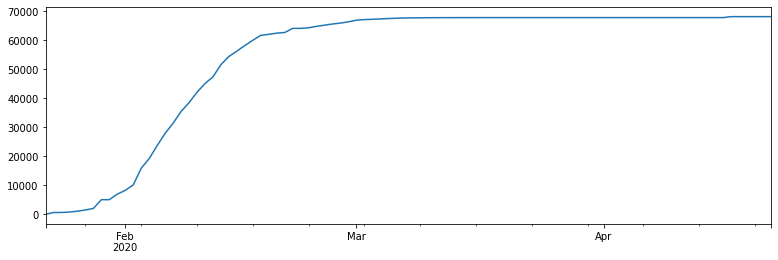

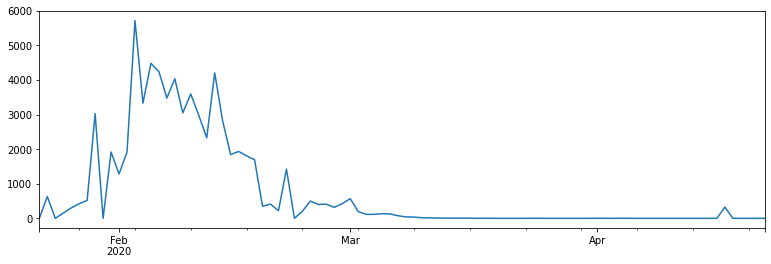

In [ ]:
def fix_hubei_data(sub_data):
    index = np.where(sub_data.index == '2020-02-12')[0][0] + 1
    # Shift data one day to the future
    sub_data.iloc[:index] = np.concatenate([np.zeros([1,]), sub_data.iloc[:index-1].values])

    # Apply parameter to normalize lab tested cases and clinical + lab tested cases
    sub_data.iloc[:index] = sub_data.iloc[:index] * (1 + 15384 / 36602)
    sub_data.iloc[index] = sub_data.iloc[index] * (0.65 + 15384 / 36602)

    return sub_data

# Fix Hubei data
if 'China-Hubei' in sdf.columns:
    sdf['China-Hubei'] = fix_hubei_data(sdf['China-Hubei'])

sdf['China-Hubei'].plot(figsize=(13, 4))
plt.figure()
sdf['China-Hubei'].diff().fillna(0).plot(figsize=(13, 4))

## Normalize by day of first case

In [ ]:
# Normalize data by the day of the first case
date_index = pd.DatetimeIndex(sdf.index)
day_of_first_case = sdf.ne(0).idxmax()
shifts = []
for region in sdf.columns:
    shift_index = np.where(sdf.index == day_of_first_case[region])[0][0]
    sdf[region] = sdf[region].shift(-1 * shift_index, fill_value=np.nan) #sdf[region][-1])
    shifts.append(shift_index)

sdf.index = np.arange(len(sdf.index))
shifts_df = pd.DataFrame(np.expand_dims(np.array(shifts), 0), columns=sdf.columns)
day_of_first_case

Province/State
Afghanistan                        2020-02-24
Albania                            2020-03-09
Algeria                            2020-02-25
Andorra                            2020-03-02
Angola                             2020-03-20
                                      ...    
France-Saint Pierre and Miquelon   2020-04-05
South Sudan                        2020-04-05
Western Sahara                     2020-04-05
Sao Tome and Principe              2020-04-06
Yemen                              2020-04-10
Length: 264, dtype: datetime64[ns]

## Plot some data

In [ ]:
all_regions = sdf.columns
print ('List of available countries or regions: ' + str(all_regions))
sdf

List of available countries or regions: Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia-Australian Capital Territory', 'Australia-New South Wales',
       ...
       'Burundi', 'Sierra Leone',
       'Netherlands-Bonaire, Sint Eustatius and Saba', 'Malawi',
       'United Kingdom-Falkland Islands (Malvinas)',
       'France-Saint Pierre and Miquelon', 'South Sudan', 'Western Sahara',
       'Sao Tome and Principe', 'Yemen'],
      dtype='object', name='Province/State', length=264)


Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,Canada-British Columbia,Canada-Grand Princess,Canada-Manitoba,Canada-New Brunswick,...,Uruguay,US,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada-Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Canada-Recovered,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada-Northwest Territories,Canada-Yukon,Kosovo,Burma,United Kingdom-Anguilla,United Kingdom-British Virgin Islands,United Kingdom-Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands-Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom-Falkland Islands (Malvinas),France-Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen
0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,...,4.0,1.0,1.0,2.0,2.0,2.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,4.0,2.0,2.0,2.0,1.0,3.0,71.0,8.0,2.0,2.0,4.0,2.0,3.0,2.0,1.0,2.0,3.0,1.0,1.0,1.0,4.0,4.0,1.0
1,1.0,10.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,23.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,4.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,...,4.0,1.0,6.0,10.0,2.0,2.0,3.0,-1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,7.0,2.0,4.0,2.0,1.0,3.0,86.0,8.0,2.0,2.0,4.0,2.0,4.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,4.0,4.0,1.0
2,1.0,12.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,0.0,2.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,33.0,3.0,5.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,11.0,4.0,2.0,3.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0,...,8.0,2.0,10.0,17.0,2.0,2.0,3.0,-1.0,2.0,1.0,3.0,1.0,1.0,2.0,0.0,6.0,1.0,16.0,2.0,11.0,2.0,1.0,4.0,91.0,10.0,2.0,2.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,4.0,4.0,1.0
3,1.0,23.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,4.0,0.0,3.0,2.0,1.0,1.0,2.0,3.0,3.0,3.0,33.0,3.0,5.0,1.0,1.0,2.0,1.0,10.0,3.0,2.0,11.0,7.0,2.0,3.0,1.0,2.0,7.0,1.0,2.0,7.0,1.0,...,29.0,2.0,15.0,33.0,2.0,2.0,3.0,-1.0,7.0,1.0,5.0,5.0,1.0,2.0,0.0,6.0,1.0,16.0,2.0,18.0,2.0,1.0,4.0,94.0,14.0,2.0,3.0,5.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,4.0,4.0,1.0
4,1.0,33.0,1.0,1.0,3.0,1.0,8.0,1.0,2.0,4.0,0.0,2.0,2.0,1.0,2.0,2.0,9.0,6.0,3.0,36.0,3.0,6.0,1.0,1.0,2.0,1.0,10.0,3.0,2.0,37.0,7.0,2.0,3.0,1.0,2.0,7.0,1.0,8.0,8.0,2.0,...,50.0,5.0,23.0,36.0,2.0,3.0,3.0,-1.0,11.0,7.0,7.0,5.0,1.0,2.0,0.0,8.0,3.0,19.0,2.0,18.0,2.0,1.0,4.0,94.0,15.0,2.0,3.0,6.0,9.0,4.0,3.0,4.0,2.0,5.0,5.0,1.0,3.0,4.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2926.0,NaN,NaN,NaN,NaN,1319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,732197.0,NaN,NaN,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,758809.0,NaN,NaN,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Total number of places (Province/State/Country/Region): 5


Province/State
China-Hubei   2020-01-23
Italy         2020-01-31
Brazil        2020-02-26
dtype: datetime64[ns]

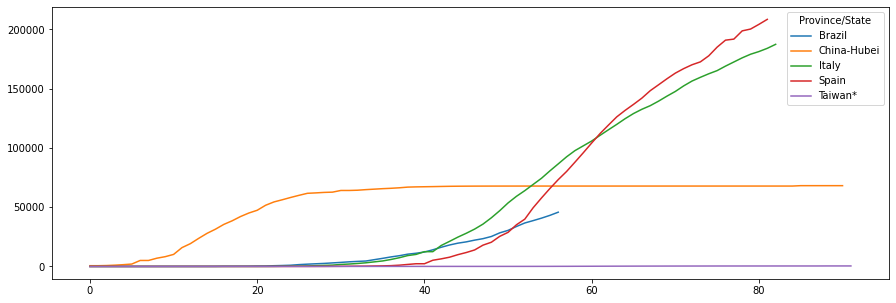

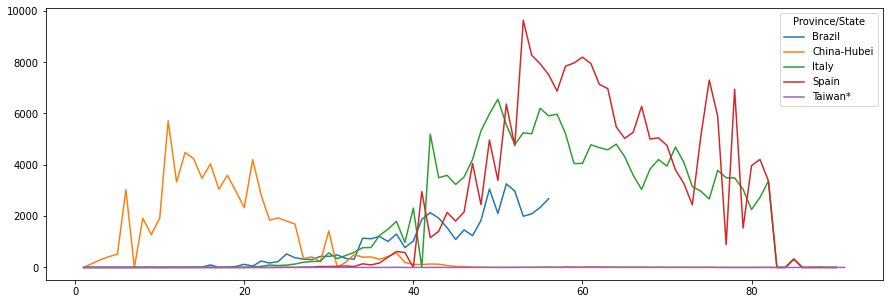

In [ ]:
# Select which countries/regions to use on the dataset
selected_regions = ['China-Hubei', 'Taiwan*', 'Italy', 'Brazil', 'Spain']
rdf = sdf.loc[:, sdf.columns.str.contains(r'|'.join(selected_regions))]

print('Total number of places (Province/State/Country/Region): ' + str(len(rdf.columns)))
rdf.plot(figsize=(15, 5))
rdf.diff().fillna(axis=1, method='ffill').plot(figsize=(15, 5))
day_of_first_case.loc[['China-Hubei', 'Italy', 'Brazil']]

## Data Preprocessing

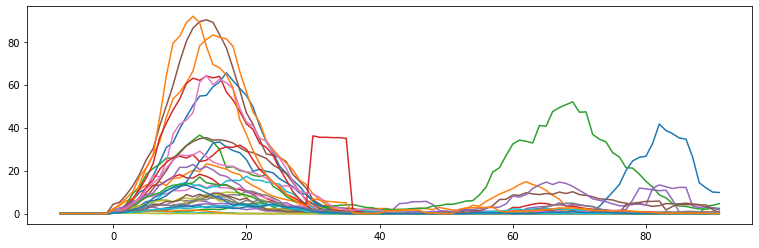

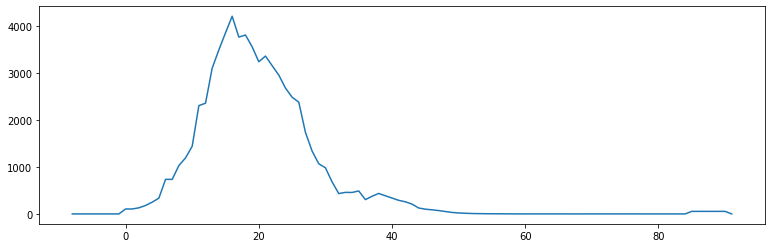

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_data(df, regions=['China'], pad_start=None, pad_end=None, normalize=None, average_size=1):
    # Select which countries/regions to use on the dataset
    if regions:
        data = df.loc[:, df.columns.str.contains(r'|'.join(regions))]
    else:
        data = df

    if pad_start:
        # Pad the Begging and End of data
        beg_index = -1 * np.arange(pad_start, 0, -1)
        beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(data.columns)]),
                        columns=data.columns,
                        index=beg_index)
        data = pd.concat([beg_zero_df, data], axis=0)
        
    if pad_end:
        end_index = np.arange(data.index[-1], data.index[-1] + pad_end)
        end_zero_df = pd.DataFrame(np.nan * np.ones([len(end_index), len(data.columns)]),
                        columns=data.columns,
                        index=end_index)
        
        data = pd.concat([data, end_zero_df], axis=0)

    # Differentiate to obtain daily cases
    # data = data.diff(axis=0).astype(np.float32)
    # data = data.diff(axis=0).fillna(0.0).astype(np.float32)
    data = data.diff(axis=0).fillna(data).astype(np.float32)
    # data = data.diff(axis=0).fillna(data).astype(np.float32)

    # Moving Average
    data = data.rolling(average_size, min_periods=1).mean() #.fillna(data)
    
    # Normalizing
    scaler = None
    if normalize == 'MinMax':
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
    if normalize == 'Standard':
        scaler = StandardScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])

    return data, scaler

data, _ = get_data(sdf, regions=['China'], pad_start=8, normalize=None, average_size=6)
data.loc[:, data.columns != 'China-Hubei'].fillna(0.0).plot(figsize=(13, 4), legend=False)
plt.figure(); data['China-Hubei'].plot(figsize=(13,4))

# Modified Auto-Encoder, MAE

## Sequences Generation

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

class MAEtsGenerator(TimeseriesGenerator):
    def __init__(self, *args, **kwargs):
        self.norm = kwargs.pop('normalization')
        super(MAEtsGenerator, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        samples, targets = super().__getitem__(index)
        samples = np.reshape(np.transpose(samples, [0, 2, 1]), [-1, self.length])
        targets = np.reshape(np.expand_dims(targets, -1), [-1, 1])

        # Normalizing
        if self.norm == 'Standard':
            S = samples.std(axis=1, keepdims=True)
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples - M, S, out=np.zeros_like(samples), where=S!=0)
            targets = np.divide(targets - M, S, out=np.zeros_like(targets), where=S!=0)

        if self.norm == 'DivMean':
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples, M, out=np.zeros_like(samples), where=M!=0)
            targets = np.divide(targets, M, out=np.zeros_like(targets), where=M!=0)
        
        if self.norm == 'MinMax':
            max = samples.max(axis=1, keepdims=True)
            min = samples.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            samples = np.divide(samples - min, minmaxdiff, out=np.zeros_like(samples), where=minmaxdiff!=0)
            targets = np.divide(targets - min, minmaxdiff, out=np.zeros_like(targets), where=minmaxdiff!=0)
        return samples, [samples, targets]

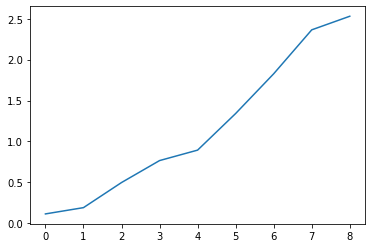

In [ ]:
def get_sequence_generator(data, normalization='divmean', length=8, shuffle=True, batch_size=1):
    generator = MAEtsGenerator(data.values, data.values, length=length, batch_size=batch_size, normalization=normalization, shuffle=shuffle)
    return generator

generator = get_sequence_generator(data, normalization='DivMean', shuffle=False)
train_exs = 0
for i, (x, y) in enumerate(generator):
    train_exs += 1

x, y = generator[9]
plt.plot(np.concatenate([x[0,:], y[1][0]]))

## Training Loop

In [ ]:
# def train_loop(train_generator, validation_data, epochs, callbacks):
#     for epoch in range(epochs):

def train(models, train_generator, eval_generator, lr=1e-3, epochs=100, weights=[1.0, 10.0]):
    def train_model(model):
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0),
            # tf.keras.callbacks.ModelCheckpoint(workspace + '/Checkpoints/MAE', monitor='val_loss', save_best_only=True, verbose=0)
        ]

        model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), 
                      loss={'ae_output': 'mean_squared_error', 
                            'pred_output': 'mean_squared_error'},
                      loss_weights={'ae_output': weights[0],
                                    'pred_output': weights[1]})


        trace = model.fit(train_generator, epochs=epochs, validation_data=eval_generator, callbacks=callbacks, verbose=0)
        # tf.keras.backend.clear_session()
        return trace
    return [train_model(model) for model in models]

## Evaluation Loop

In [ ]:
def evaluate(models, generator, forecast_start_day=15, normalization='divmean'):
    xi, yi = generator[0]
    eval_models = [tf.keras.Model(model.inputs, [model.outputs[1], model.get_layer('latent_space').output]) for model in models]

    predicted_values = np.zeros([xi.shape[0], 0])
    true_values = np.zeros([xi.shape[0], 0])
    latent_space = np.zeros([len(models), xi.shape[0], models[0].get_layer('latent_space').output.shape[1], 0])

    # Iterate over a set with support data
    for i, (ex, y) in enumerate(generator):
        if i < forecast_start_day:
            x = ex
        # Normalize
        if normalization == 'Standard':
            S = x.std(axis=1, keepdims=True)
            M = x.mean(axis=1, keepdims=True)
            x = np.divide(x - M, S, out=np.zeros_like(x), where=S!=0)
        if normalization == 'DivMean':
            M = x.mean(axis=1, keepdims=True)
            x = np.divide(x, M, out=np.zeros_like(x), where=M!=0)
        if normalization == 'MinMax':
            max = x.max(axis=1, keepdims=True)
            min = x.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            x = np.divide(x - min, minmaxdiff, out=np.zeros_like(x), where=minmaxdiff!=0)
        # Predict
        outs = [eval_model.predict(x) for eval_model in eval_models]
        # Average models predictions
        pred = np.array([out[0] for out in outs]).mean(0)
        # Restore
        if normalization == 'Standard':
            pred = pred * S + M
            x = x * S + M
        if normalization == 'DivMean':
            pred = pred * M
            x = x * M
        if normalization == 'MinMax':
            pred = pred * minmaxdiff + min
            x = x * minmaxdiff + min
        # Append
        predicted_values = np.concatenate([predicted_values, pred], axis=1)
        true_values = np.concatenate([true_values, y[1]], axis=1)
        latent_space = np.concatenate([latent_space, np.expand_dims(np.array([out[1] for out in outs]), -1)], axis=3)
        # Shift
        x = np.concatenate([x, pred], axis=1)[:, 1:]        

    return predicted_values.T, true_values.T, latent_space.transpose([0, 1, 3, 2])

## Dense MAE Model

In [ ]:
# Parameters
train_regions = ['China', 'Taiwan*']
eval_regions = ['Italy']
num_models = 5
data_normalization = None
block_normalization = 'DivMean'
sequence_length = 8
lr = 1e-2
pad_start = sequence_length
average_size = 3

### Defining Model

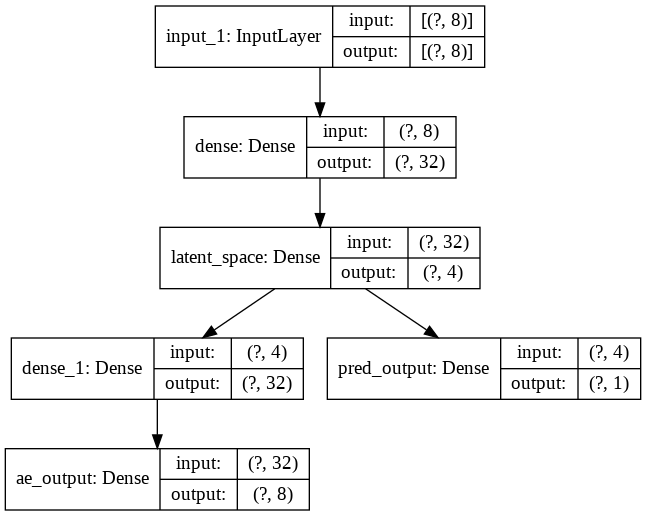

In [ ]:
def make_mae_dense_model(sequence_length=8):
    # MAE Model 
    in_mae = tf.keras.Input(shape=(sequence_length,))
    mae = tf.keras.layers.Dense(32, activation='relu')(in_mae)
    mae = tf.keras.layers.Dense(4, activation='relu', name='latent_space')(mae)
    pred = tf.keras.layers.Dense(1, activation='linear', name='pred_output')(mae)
    mae = tf.keras.layers.Dense(32, activation='relu')(mae)
    mae = tf.keras.layers.Dense(8, activation='linear', name='ae_output')(mae)


    mae_model = tf.keras.Model(in_mae, [mae, pred], name='MAE')
    return mae_model

mae_models = [make_mae_dense_model(sequence_length) for _ in range(num_models)]
from tensorflow.keras.utils import plot_model
plot_model(mae_models[0], show_shapes=True, show_layer_names=True, to_file='model.png')

### Training

In [ ]:
train_data, _ = get_data(sdf, regions=train_regions, pad_start=pad_start, pad_end=None, normalize=data_normalization, average_size=average_size)
eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=None, normalize=data_normalization, average_size=average_size)

train_generator = get_sequence_generator(train_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=True, batch_size=4)
eval_generator = get_sequence_generator(eval_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=True, batch_size=4)

traces = train(mae_models, train_generator, eval_generator, lr=lr, epochs=100)

for i,trace in enumerate(traces):
    pd.DataFrame(np.stack([trace.history['ae_output_loss'], 
                           trace.history['val_ae_output_loss']], axis=1), 
                 columns={'ae_loss', 'val_ae_loss'}).plot(figsize=(13, 4), title='Model %d' % i)
    pd.DataFrame(np.stack([trace.history['pred_output_loss'], 
                           trace.history['val_pred_output_loss']], axis=1), 
                 columns={'pred_loss', 'val_pred_loss'}).plot(figsize=(13, 4), title='Model %d' % i)

# from itertools import zip_longest
# pd.DataFrame(np.column_stack(list(zip_longest(*[np.array(tr.history['ae_output_loss']) for tr in traces], fillvalue=np.nan)))).T.plot(figsize=(20, 5), title='ae_loss')
# pd.DataFrame(np.column_stack(list(zip_longest(*[np.array(tr.history['val_ae_output_loss']) for tr in traces], fillvalue=np.nan)))).T.plot(figsize=(20, 5), title='val_ae_loss')
# pd.DataFrame(np.column_stack(list(zip_longest(*[np.array(tr.history['pred_output_loss']) for tr in traces], fillvalue=np.nan)))).T.plot(figsize=(20, 5), title='pred_loss')
# pd.DataFrame(np.column_stack(list(zip_longest(*[np.array(tr.history['val_pred_output_loss']) for tr in traces], fillvalue=np.nan)))).T.plot(figsize=(20, 5), title='val_pred_loss')


### (Optinional) - Load Models from files

In [ ]:
from os import listdir
from google.colab import drive
drive.mount('/content/drive')
workspace = '/content/drive/My Drive/Colab Notebooks/COVID19'
df_folder = workspace + '/MimmoData/'
model_folder = df_folder + '/models_trained_on_china_z4_avg3/'

for i, model in enumerate(mae_models):
    model.load_weights(model_folder + 'model_weights%d' % i)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Forecasting

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.divide(np.abs(y_true - y_pred), y_true, out=np.ones_like(y_true) * np.nan, where=y_true!=0), axis=0) * 100

#### China

                            MAPE      XCOR
Province/State                            
China-Anhui            35.097930  0.994091
China-Beijing          57.154086  0.957467
China-Chongqing        30.307343  0.974124
China-Fujian           34.312375  0.969597
China-Gansu            56.303685  0.868036
China-Guangdong        32.783184  0.993486
China-Guangxi          31.199635  0.965039
China-Guizhou          36.729621  0.952748
China-Hainan           34.431860  0.951084
China-Hebei           141.621285  0.934765
China-Heilongjiang     59.278728  0.522727
China-Henan            39.221574  0.991774
China-Hong Kong        44.198342  0.947702
China-Hubei            41.773594  0.980372
China-Hunan            34.182760  0.993647
China-Inner Mongolia  179.126565  0.554703
China-Jiangsu          32.605494  0.996434
China-Jiangxi          49.162015  0.980771
China-Jilin            46.259065  0.958059
China-Liaoning        354.484375  0.541308
China-Macau            42.510737  0.928727
China-Ningx

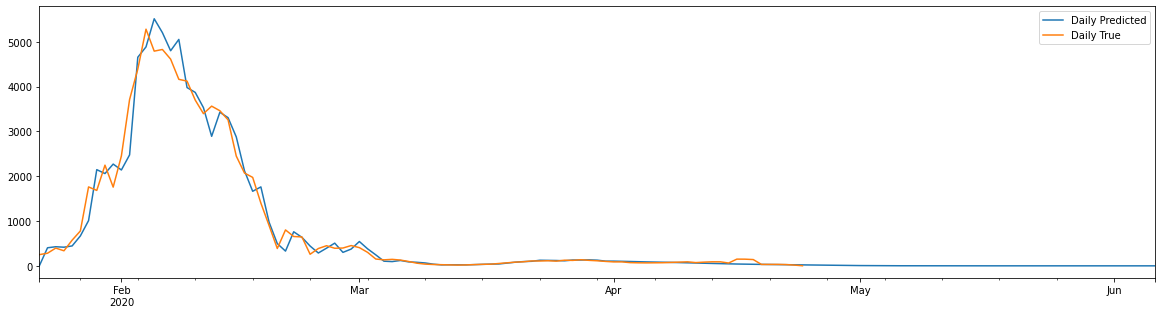

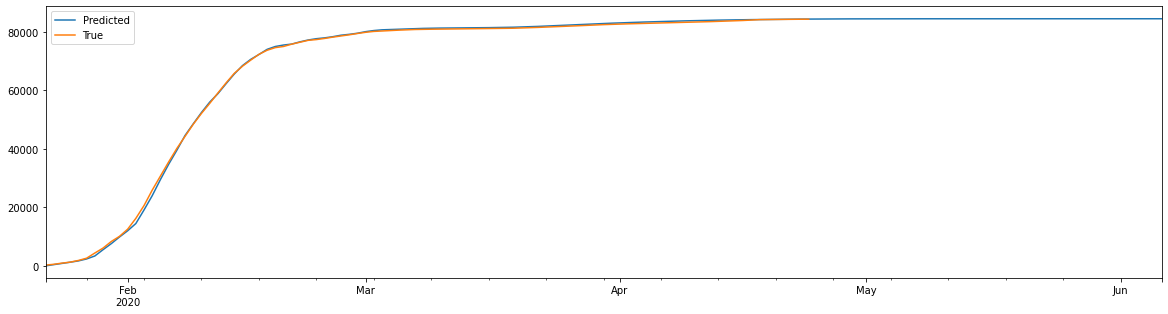

In [ ]:
eval_regions = ['China', 'Taiwan*']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Italy

                     MAPE      XCOR
Province/State                     
Italy           38.204309  0.814051
MAPE    38.204309
XCOR     0.814051
dtype: float64


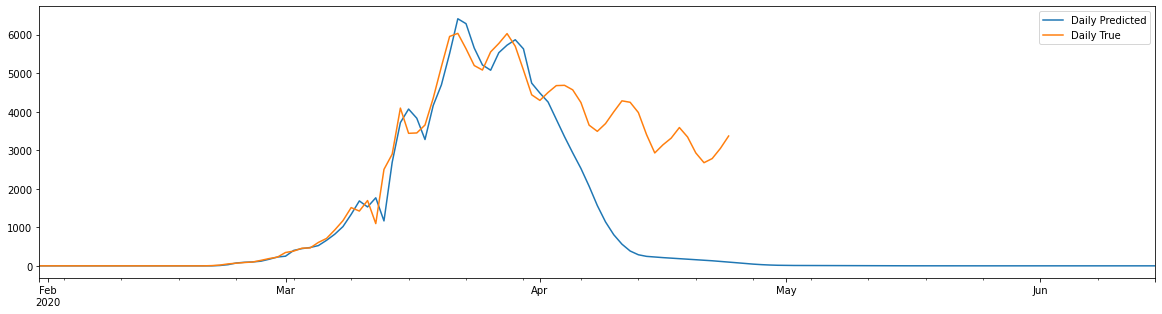

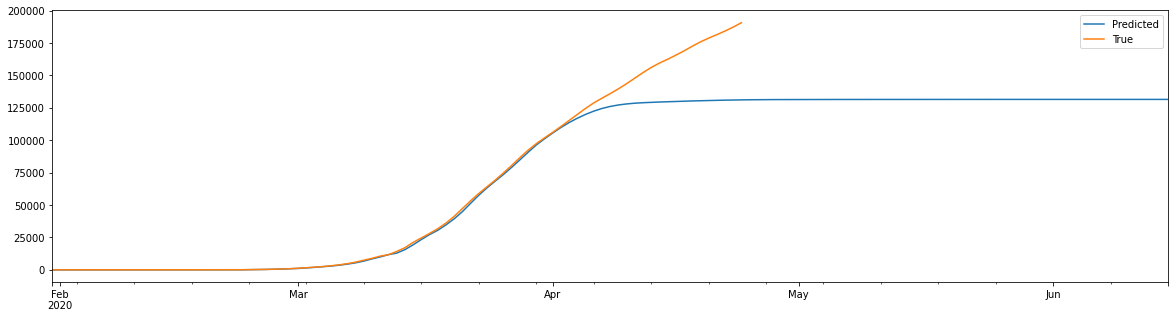

In [ ]:
eval_regions = ['Italy']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Brazil

                     MAPE      XCOR
Province/State                     
Brazil          55.639437 -0.077595
MAPE    55.639437
XCOR    -0.077595
dtype: float64


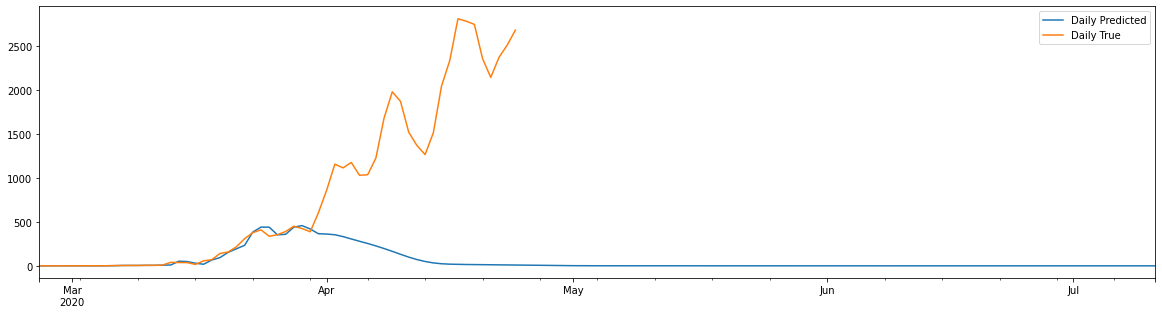

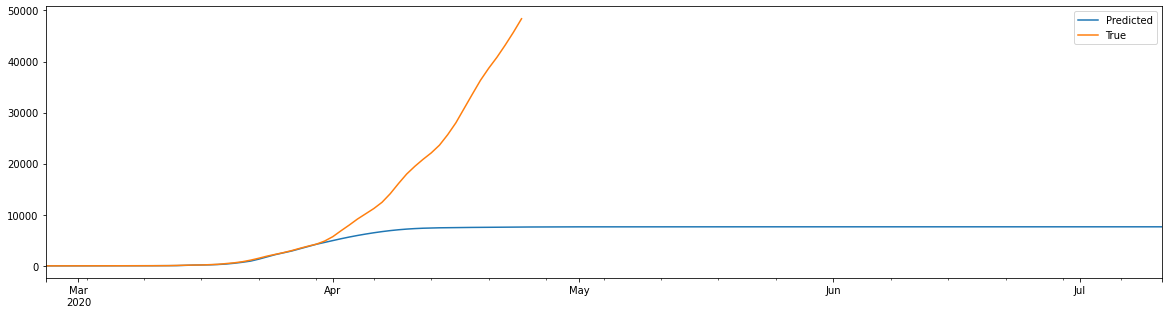

In [ ]:
eval_regions = ['Brazil']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Spain

                     MAPE      XCOR
Province/State                     
Spain           33.924628  0.889223
MAPE    33.924628
XCOR     0.889223
dtype: float64


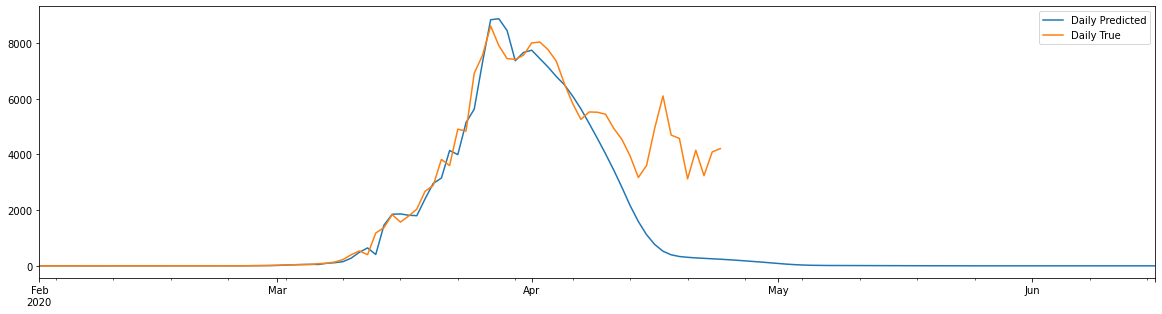

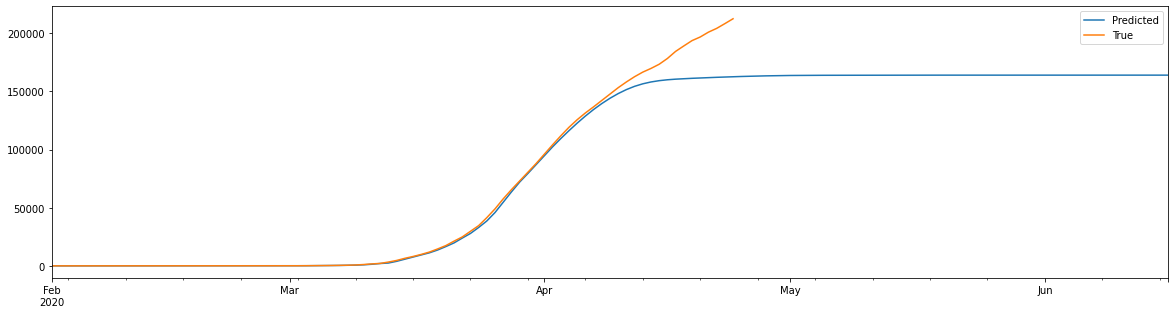

In [ ]:
eval_regions = ['Spain']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### UK

                                                 MAPE      XCOR
Province/State                                                 
United Kingdom-Bermuda                      75.162837  0.727487
United Kingdom-Cayman Islands               69.166145  0.790871
United Kingdom-Channel Islands              47.559671  0.901687
United Kingdom-Gibraltar                    49.981375  0.872549
United Kingdom-Isle of Man                  40.357249  0.804584
United Kingdom-Montserrat                   62.979009  0.640636
United Kingdom                              44.982727  0.798380
United Kingdom-Anguilla                     55.856299  0.694525
United Kingdom-British Virgin Islands       49.821332  0.722048
United Kingdom-Turks and Caicos Islands     60.060265  0.655444
United Kingdom-Falkland Islands (Malvinas)  58.230810  0.629236
MAPE    55.832520
XCOR     0.748859
dtype: float64


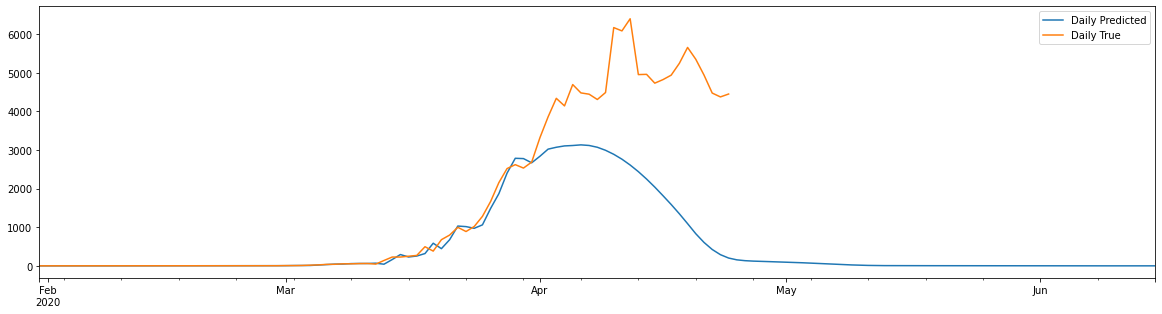

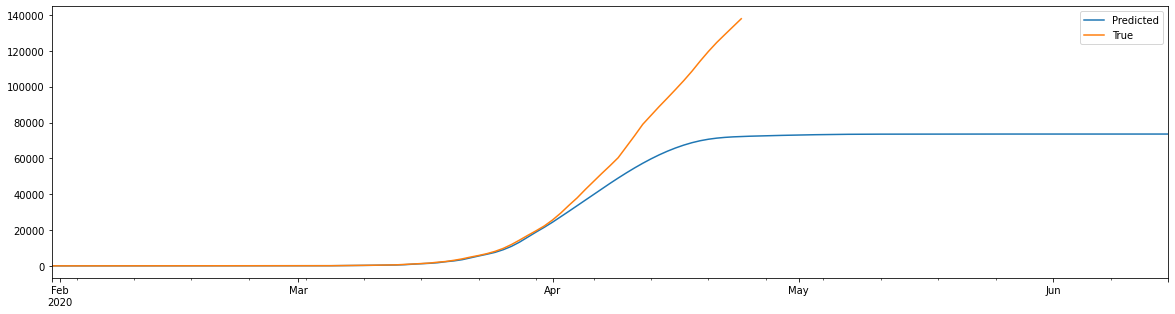

In [ ]:
eval_regions = ['United Kingdom']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df['United Kingdom'].values, trues_df['United Kingdom'].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df['United Kingdom'].cumsum().values, trues_df['United Kingdom'].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### US

                     MAPE      XCOR
Province/State                     
US              41.567748  0.881083
MAPE    41.567748
XCOR     0.881083
dtype: float64


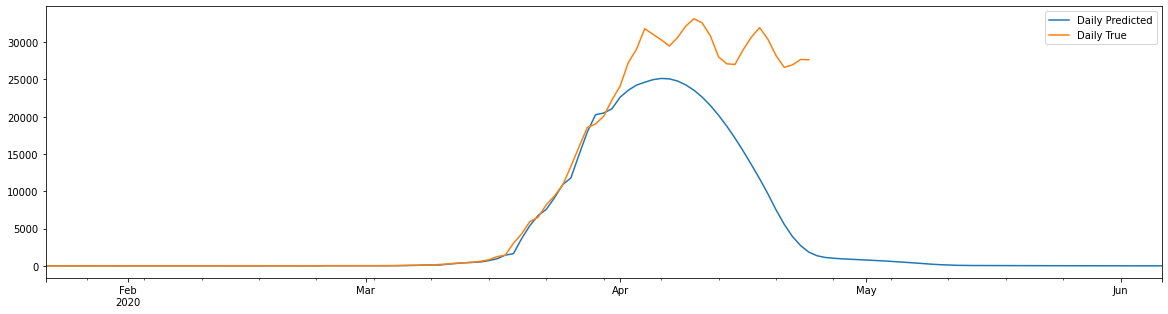

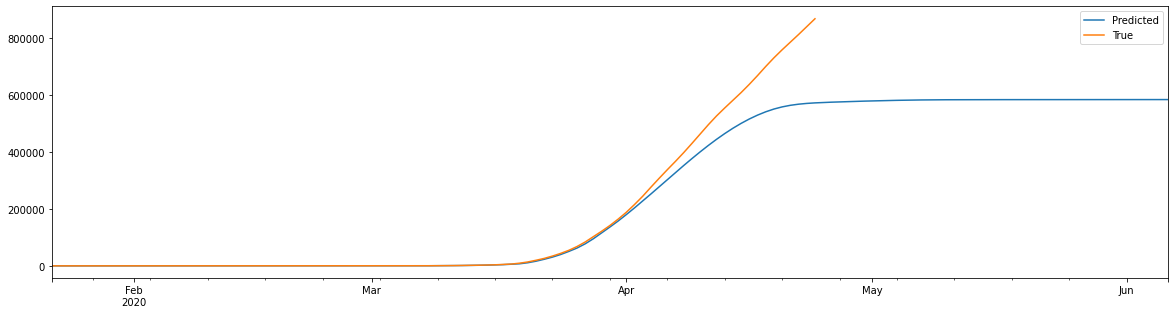

In [ ]:
eval_regions = ['US']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### France

                                       MAPE      XCOR
Province/State                                       
France-French Guiana              66.217778  0.692906
France-French Polynesia           57.806240  0.751408
France-Guadeloupe                 44.504720  0.857051
France-Mayotte                    38.753797  0.791771
France-New Caledonia              70.575621  0.873043
France-Reunion                    39.833681  0.932465
France-Saint Barthelemy           35.529310  0.527314
France-St Martin                  44.468454  0.801015
France-Martinique                 54.271020  0.838060
France                            37.726982  0.635440
France-Saint Pierre and Miquelon  70.479465  0.715345
MAPE    50.924279
XCOR     0.765074
dtype: float64


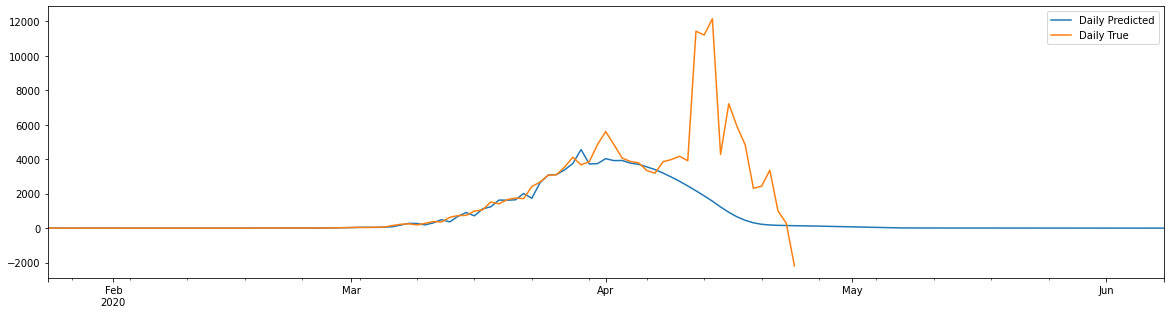

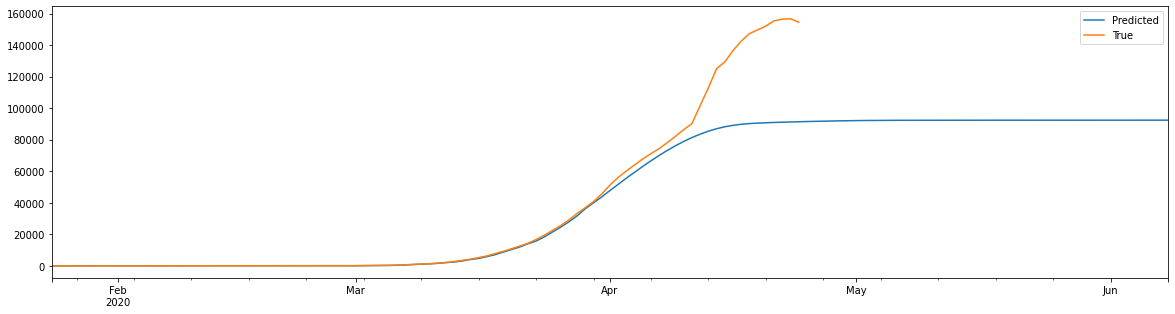

In [ ]:
eval_regions = ['France']
forcast_start_date = '2020-04-01'
# average_size = 3
pad_start = sequence_length
pad_end = 45

min_start_day = day_of_first_case.loc[day_of_first_case.index.str.contains(r'|'.join(eval_regions))].min()
forecast_start_day = (pd.to_datetime(forcast_start_date) - min_start_day).days

eval_data, _ = get_data(sdf, regions=eval_regions, pad_start=pad_start, pad_end=pad_end, normalize=data_normalization, average_size=average_size)
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=min_start_day, periods=preds.shape[0]))

pd.DataFrame(np.stack([predicted_df['France'].values, trues_df['France'].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df['France'].cumsum().values, trues_df['France'].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

### Italy - Mimmo Data

In [ ]:
forecast_start_date = '2020-04-01'
average_size = 3
pad_start = sequence_length
pad_end = 60

#### Data Preprocessing

(59, 21)


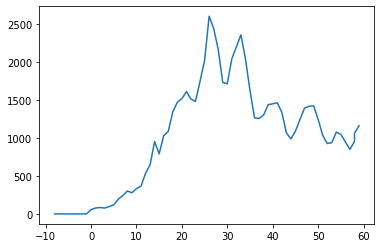

In [ ]:
ddf = pd.read_json('dpc-covid19-ita-regioni.json')
posdf = ddf[['denominazione_regione', 'lat', 'long']].drop_duplicates()
regions = ddf.denominazione_regione.unique()
ddf.data = pd.to_datetime(ddf.data)
ddf.set_index(ddf.data)
dates = ddf.data.unique()


mdf = pd.DataFrame(index=np.arange(len(dates)), columns=regions)
for region in regions:
    mdf[region] = ddf[ddf.denominazione_regione == region]['nuovi_positivi'].cumsum().values

eval_data, _ = get_data(mdf, regions=None, pad_start=pad_start, pad_end=pad_end, normalize=None, average_size=average_size)
eval_data['Lombardia'].plot()
print(mdf.shape)

#### Forecasting

In [ ]:
forecast_start_day = (pd.to_datetime(forcast_start_date) - dates[0]).days
generator = get_sequence_generator(eval_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues, zs = evaluate(mae_models, generator, forecast_start_day=forecast_start_day, normalization=block_normalization)
predicted_df = pd.DataFrame(preds, columns=eval_data.columns, index=pd.date_range(start=dates[0], periods=preds.shape[0]))
trues_df = pd.DataFrame(trues, columns=eval_data.columns, index=pd.date_range(start=dates[0], periods=preds.shape[0]))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)

corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

                             MAPE      XCOR
Abruzzo                 59.747180  0.719254
Basilicata             172.128180  0.596948
P.A. Bolzano            83.206846  0.761818
Calabria               185.840307  0.487763
Campania                39.394268  0.864420
Emilia-Romagna          32.465155  0.863186
Friuli Venezia Giulia   44.131245  0.815552
Lazio                   32.834981  0.857136
Liguria                 54.213139  0.616320
Lombardia               33.352692  0.810025
Marche                  38.715913  0.867110
Molise                  63.652305  0.556108
Piemonte                36.317492  0.473914
Puglia                  35.395223  0.806992
Sardegna                46.558757  0.868943
Sicilia                 50.138975  0.846901
Toscana                 33.405295  0.885429
P.A. Trento             43.062048  0.741538
Umbria                  64.216568  0.898691
Valle d'Aosta          372.539430  0.430326
Veneto                  34.273984  0.740744
MAPE    74.075713
XCOR     0.738

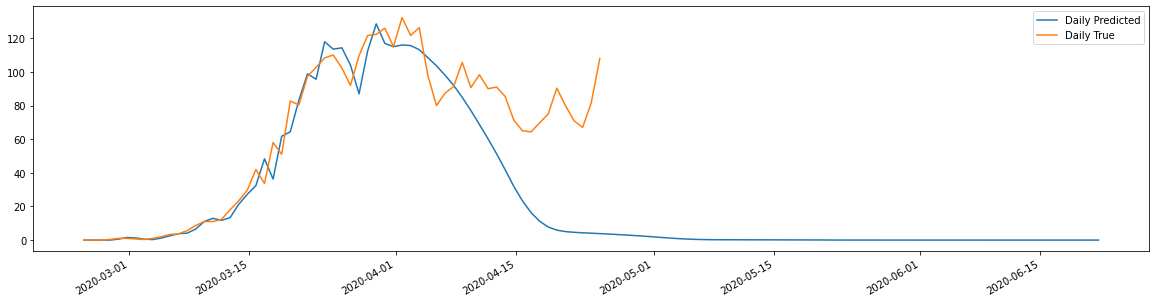

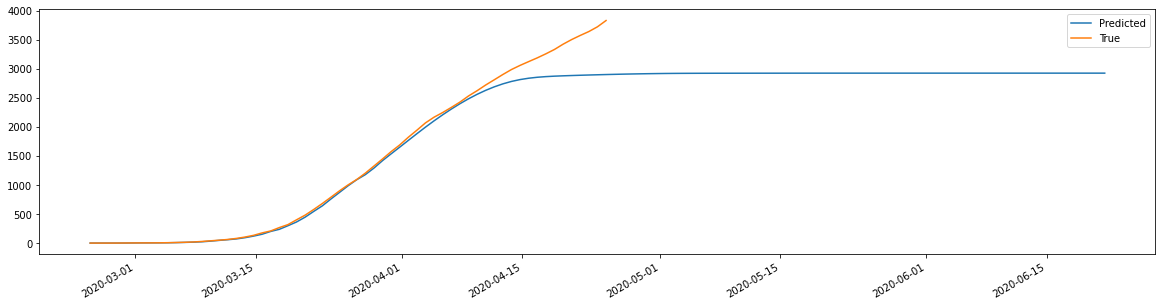

In [ ]:
region = 'Puglia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

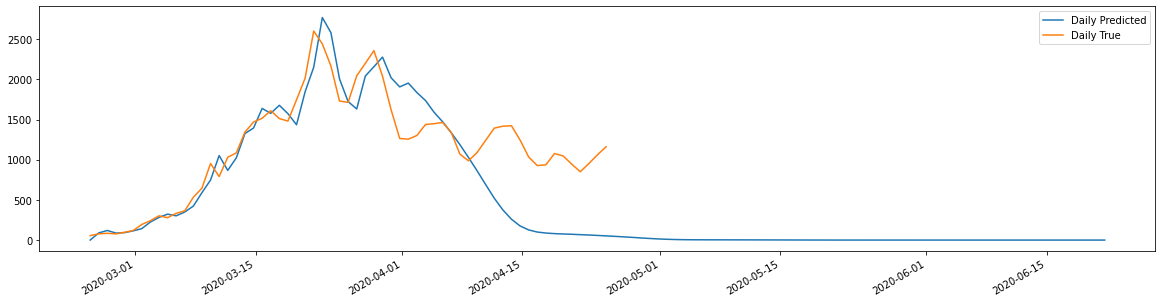

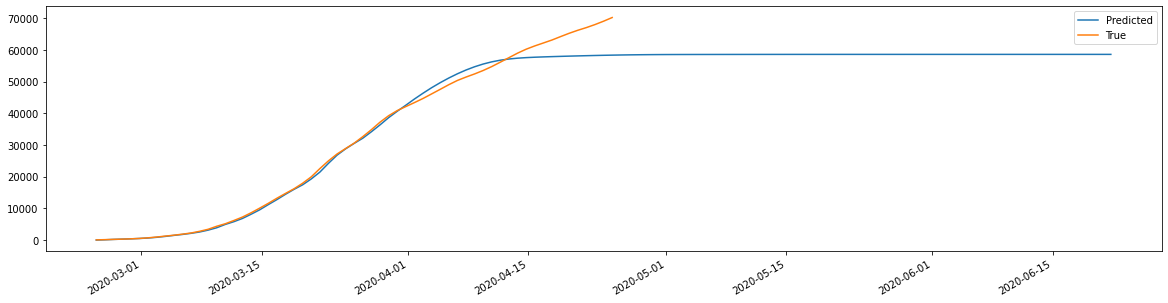

In [ ]:
region = 'Lombardia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

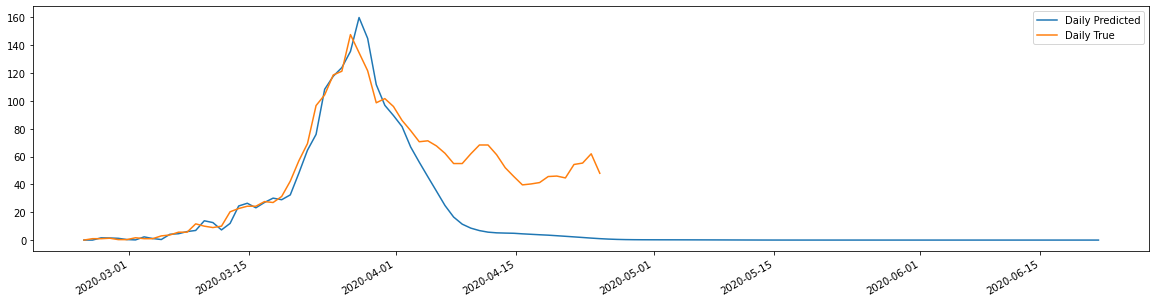

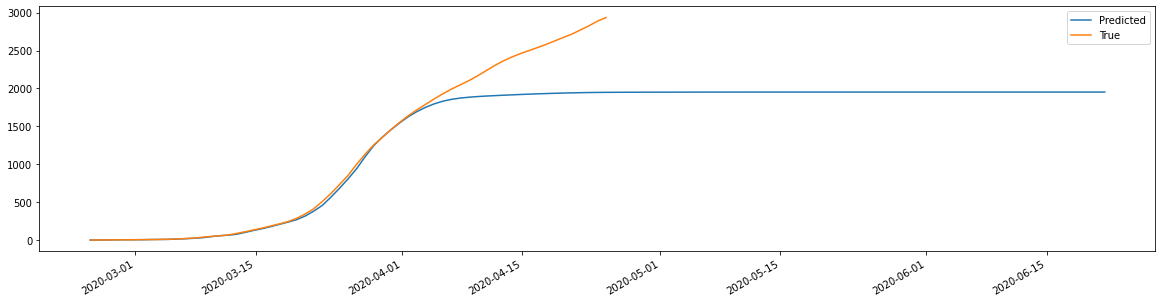

In [ ]:
region = 'Sicilia'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

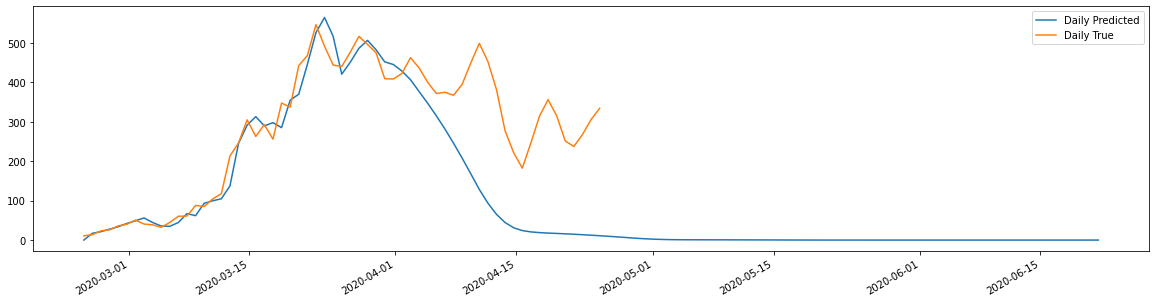

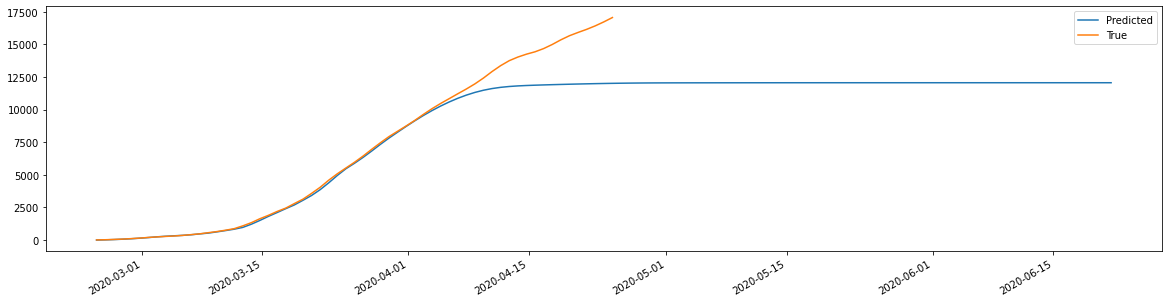

In [ ]:
region = 'Veneto'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

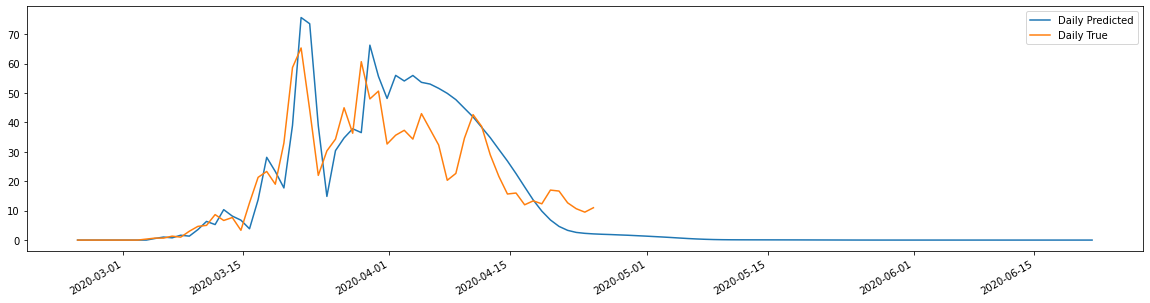

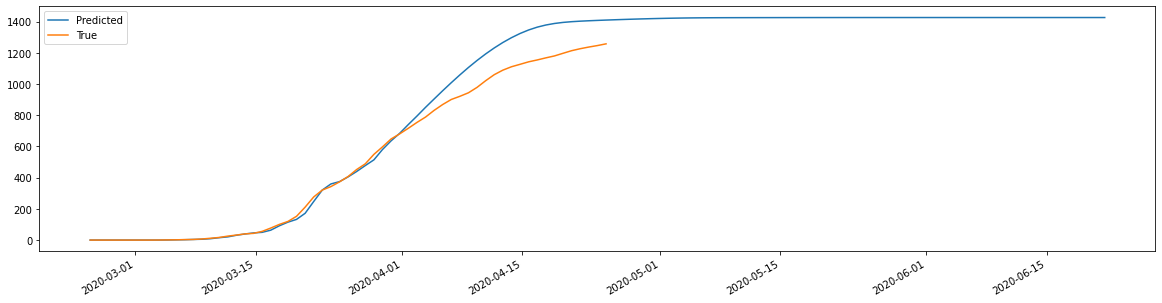

In [ ]:
region = 'Sardegna'
pd.DataFrame(np.stack([predicted_df[region].values, trues_df[region].values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df[region].cumsum().values, trues_df[region].cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

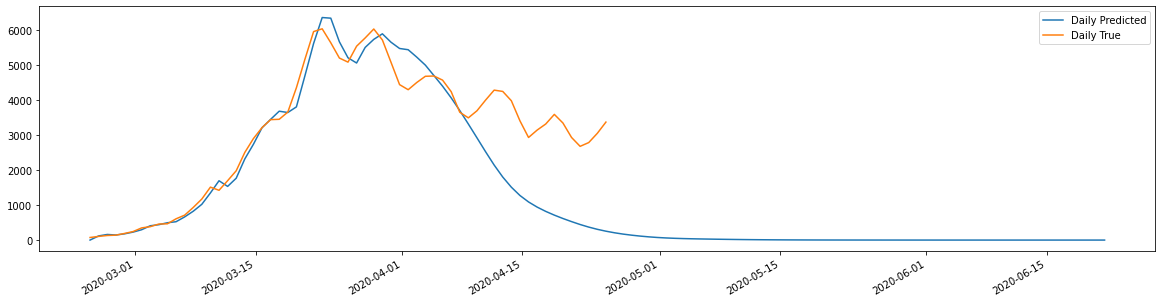

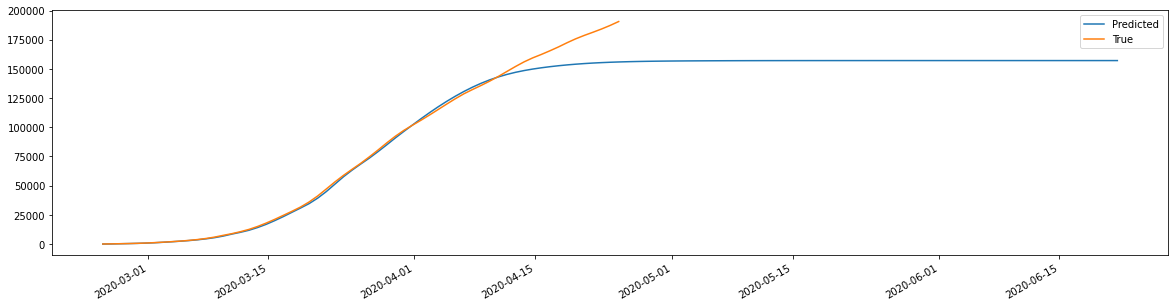

In [ ]:
# Summed of all Italy Cities
pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

#### Clustering

In [ ]:
mzs = zs.mean(axis=2)
svds = np.linalg.svd(mzs.transpose([1, 0, 2]))

##### Find Best Number of Clusters

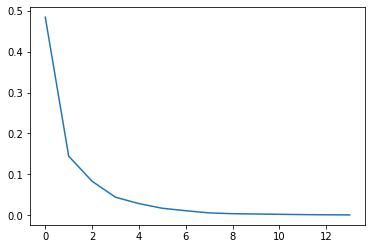

In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(svds[1])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(Sum_of_squared_distances)

##### Cluster by Lat and Long

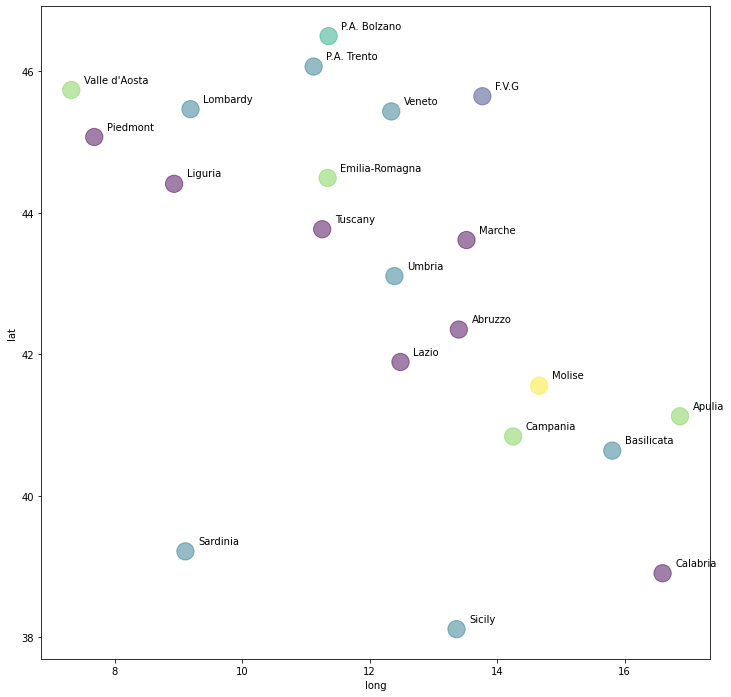

In [ ]:
posdf.replace(['Puglia', 'Friuli Venezia Giulia', 'Lombardia', 'Piemonte', 'Sardegna', 'Sicilia', 'Toscana'], 
              ['Apulia', 'F.V.G', 'Lombardy', 'Piedmont', 'Sardinia', 'Sicily', 'Tuscany'], inplace=True)

estimator = KMeans(n_clusters=6)
labels = estimator.fit_predict(svds[1])
ax = posdf.plot.scatter(x='long', y='lat', c=labels.astype(float), colormap='viridis', colorbar=False, figsize=(12, 12), s=300, alpha=0.5)
posdf[['long','lat','denominazione_regione']].apply(lambda row: ax.text(row[0]+0.2, row[1]+0.1, row[2]), axis=1);
# plt.savefig(workspace + '/MimmoData/Report/' + 'cluster_n6.tif', format='tif', dpi=300)

In [ ]:
posdf['cluster'] = labels
region_clusters = posdf.groupby('cluster')['denominazione_regione'].apply(lambda x: ', '.join(x)).reset_index()
print(region_clusters.values)

[[0 'Abruzzo, Calabria, Lazio, Liguria, Marche, Piedmont, Tuscany']
 [1 'F.V.G']
 [2 'Basilicata, Lombardy, Sardinia, Sicily, P.A. Trento, Umbria, Veneto']
 [3 'P.A. Bolzano']
 [4 "Campania, Emilia-Romagna, Apulia, Valle d'Aosta"]
 [5 'Molise']]


#### Display latent space

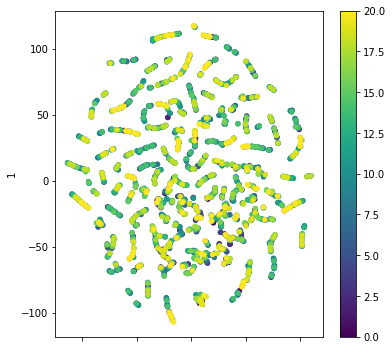

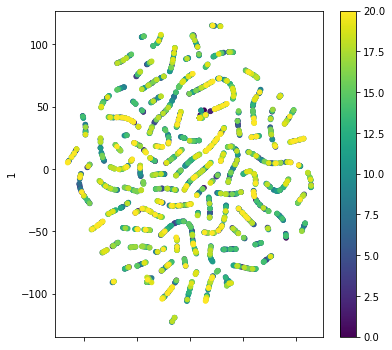

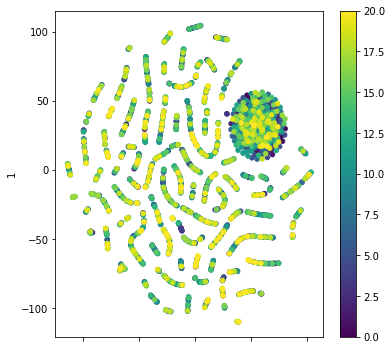

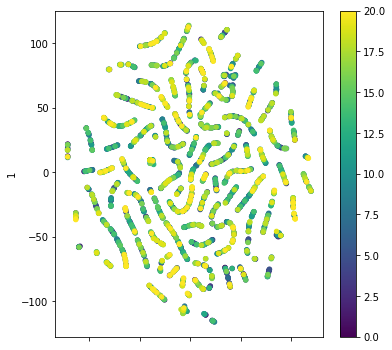

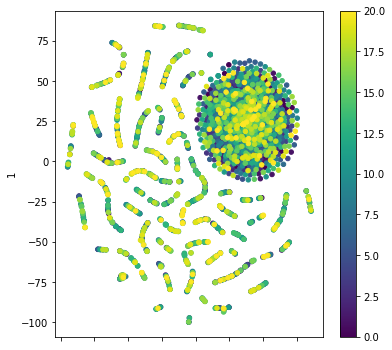

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

for m in range(len(zs)):
    tzs = zs[m]
    tdf = pd.DataFrame()
    for r in range(len(tzs)):
        tsdf = pd.DataFrame(tzs[r])
        tsdf['r'] = np.float32(r)
        tdf = tdf.append(tsdf)
    proj = TSNE(random_state=0, perplexity=5).fit_transform(tdf.iloc[:, :4])
    proj_df = pd.DataFrame(proj)
    proj_df.plot.scatter(x=0, y=1, c=tdf.iloc[:, -1], cmap='viridis', figsize=(6, 6))

#### Save Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# workspace = '/content/drive/My Drive/Colab Notebooks/COVID19'
# df_folder = workspace + '/MimmoData/train-china_z4_avg3_clustering/'
# predicted_df.to_csv(df_folder + 'predictions.csv')
# trues_df.to_csv(df_folder + 'trues.csv')

# for i, model in enumerate(mae_models):
#     model.save_weights(df_folder + 'models/model%d.h5' % i)

# Generate Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

workspace = '/content/drive/My\ Drive/Colab\ Notebooks/COVID19/'
nb_name = 'COVID19\ Time\ Series\ -\ MAE\ Dense'
!cp {workspace + nb_name} .
!jupyter nbconvert  {nb_name}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook COVID19 Time Series - MAE Dense to html
[NbConvertApp] Writing 2153215 bytes to COVID19 Time Series - MAE Dens.html
